In [ ]:
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def softplus(x):
    return pt.log1p(pt.exp(x))

In [ ]:
user_item_matrix = pd.read_csv('./Data/preprocessed_user_item_matrix.csv')

In [4]:
def train_test_split(obs_df, test_frac=0.2, random_state=42):
    np.random.seed(random_state)
    is_test = obs_df.groupby('userID').apply(
        lambda df: df.sample(frac=test_frac, random_state=random_state).index
    ).explode()

    test_idx = set(is_test)
    train_df = obs_df.drop(index=test_idx)
    test_df  = obs_df.loc[list(test_idx)]
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [5]:
n_users_sub = 100
n_artists_sub = 100
np.random.seed(42)
users = np.random.choice(user_item_matrix.index, n_users_sub, replace=False)
artists = np.random.choice(user_item_matrix.columns, n_artists_sub, replace=False)
sub_matrix = user_item_matrix.loc[users, artists]

obs = sub_matrix.stack().reset_index()
obs.columns = ['userID', 'artistID', 'listen_count']

# Log-transform the counts
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize log counts
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

obs['u_idx'] = obs['userID'].astype('category').cat.codes
obs['a_idx'] = obs['artistID'].astype('category').cat.codes

train_obs, test_obs = train_test_split(obs, test_frac=0.2)

counts = train_obs['y_scaled'].values
u_idx = train_obs['u_idx'].values
a_idx = train_obs['a_idx'].values

# Tried Negative Binomial Approach

In [10]:
n_latent = 3

with pm.Model() as nbmf_softplus:
    U = pm.Normal('U', 0, 0.5, shape=(n_users_sub, n_latent))
    V = pm.Normal('V', 0, 0.5, shape=(n_artists_sub, n_latent))
    
    r = pm.HalfNormal('r', sigma=1)
    
    dot_products = pm.math.sum(U[u_idx] * V[a_idx], axis=1)
    mu = softplus(dot_products)

    y_obs = pm.NegativeBinomial('y_obs', mu=mu, alpha=r, observed=train_obs['listen_count'].values)

    trace = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V, r]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 399 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


    mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
r  0.001  0.0   0.001    0.001        0.0      0.0    3870.0    3445.0    1.0


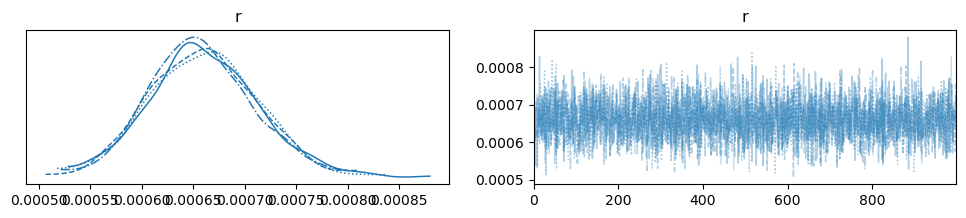

In [13]:
print(az.summary(trace, var_names=['r']))
az.plot_trace(trace, var_names=['r'])

# Posterior means
U_mean = trace.posterior['U'].mean(dim=("chain", "draw")).values
V_mean = trace.posterior['V'].mean(dim=("chain", "draw")).values
R_hat = np.exp(U_mean @ V_mean.T)


In [14]:
U_mean = trace.posterior['U'].mean(dim=("chain", "draw")).values
V_mean = trace.posterior['V'].mean(dim=("chain", "draw")).values

# Predict expected listen counts
R_hat = np.exp(U_mean @ V_mean.T)


In [15]:
user_map = {userID: idx for idx, userID in enumerate(sub_matrix.index)}
artist_map = {artistID: idx for idx, artistID in enumerate(sub_matrix.columns)}


In [ ]:
y_true = test_obs['listen_count'].values
y_pred = np.array([
    np.clip(mu_hat, 0, 1e5)  # optional: cap extreme predictions
    for (userID, artistID) in zip(test_obs['userID'], test_obs['artistID'])
    if userID in user_map and artistID in artist_map
    for mu_hat in [np.exp(U_mean[user_map[userID]] @ V_mean[artist_map[artistID]])]
])


In [17]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Negative Binomial Test MSE: {mse:.2f}, MAE: {mae:.2f}")


Negative Binomial Test MSE: 136799.56, MAE: 43.27


# Tune Logged Normal Model

In [24]:
user_item_matrix = pd.read_csv('./Data/preprocessed_user_item_matrix.csv')

In [26]:
n_users_sub = 100
n_artists_sub = 100
np.random.seed(42)
users = np.random.choice(user_item_matrix.index, n_users_sub, replace=False)
artists = np.random.choice(user_item_matrix.columns, n_artists_sub, replace=False)
sub_matrix = user_item_matrix.loc[users, artists]

obs = sub_matrix.stack().reset_index()
obs.columns = ['userID', 'artistID', 'listen_count']

# Log-transform the counts
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize log counts
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

obs['u_idx'] = obs['userID'].astype('category').cat.codes
obs['a_idx'] = obs['artistID'].astype('category').cat.codes

train_obs, test_obs = train_test_split(obs, test_frac=0.2)

counts = train_obs['y_scaled'].values
u_idx = train_obs['u_idx'].values
a_idx = train_obs['a_idx'].values

In [27]:
from sklearn.preprocessing import StandardScaler

# Create log-transformed target
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

# Train/test split
train_obs, test_obs = train_test_split(obs, test_frac=0.2)


In [28]:
import pymc as pm

with pm.Model() as bmf_normal:
    # Latent factors (loosened priors)
    U = pm.Normal('U', mu=0, sigma=2, shape=(n_users_sub, n_latent))
    V = pm.Normal('V', mu=0, sigma=2, shape=(n_artists_sub, n_latent))

    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Predicted log-counts
    dot_products = pm.math.sum(
        U[train_obs['u_idx'].values] * V[train_obs['a_idx'].values],
        axis=1
    )

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=dot_products, sigma=sigma, observed=train_obs['y_scaled'].values)

    # Inference
    trace_norm = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 232 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Posterior means
U_mean = trace_norm.posterior['U'].mean(dim=('chain','draw')).values
V_mean = trace_norm.posterior['V'].mean(dim=('chain','draw')).values

R_hat = U_mean @ V_mean.T

# Map test user/artist IDs to indices
user_map = {userID: idx for idx, userID in enumerate(sub_matrix.index)}
artist_map = {artistID: idx for idx, artistID in enumerate(sub_matrix.columns)}

# Predict standardized log-counts
y_pred_scaled = np.array([
    R_hat[user_map[row.userID], artist_map[row.artistID]]
    for _, row in test_obs.iterrows()
])

# Inverse transform
y_pred_log = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_pred_final = np.expm1(y_pred_log)  # back to count space

y_true_final = test_obs['listen_count'].values

# Evaluate
mse = mean_squared_error(y_true_final, y_pred_final)
mae = mean_absolute_error(y_true_final, y_pred_final)

print(f"Refined Gaussian Model on log1p(count):\nMSE: {mse:.2f}, MAE: {mae:.2f}")


Refined Gaussian Model on log1p(count):
MSE: 136861.93, MAE: 42.57


# Back to OG with more latent dimensions

In [32]:
user_item_matrix = pd.read_csv('./Data/preprocessed_user_item_matrix.csv')

_users_sub = 100
n_artists_sub = 100
np.random.seed(42)
users = np.random.choice(user_item_matrix.index, n_users_sub, replace=False)
artists = np.random.choice(user_item_matrix.columns, n_artists_sub, replace=False)
sub_matrix = user_item_matrix.loc[users, artists]

obs = sub_matrix.stack().reset_index()
obs.columns = ['userID', 'artistID', 'listen_count']

# Log-transform the counts
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize log counts
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

obs['u_idx'] = obs['userID'].astype('category').cat.codes
obs['a_idx'] = obs['artistID'].astype('category').cat.codes

train_obs, test_obs = train_test_split(obs, test_frac=0.2)

counts = train_obs['y_scaled'].values
u_idx = train_obs['u_idx'].values
a_idx = train_obs['a_idx'].values

In [ ]:
n_latent = 5
with pm.Model() as bpmf_nuts:
    U = pm.Normal('U', 0, 1, shape=(n_users_sub, n_latent))
    V = pm.Normal('V', 0, 1, shape=(n_artists_sub, n_latent))
    sigma = pm.HalfNormal('sigma', 1)

    mu = pm.math.sum(U[u_idx] * V[a_idx], axis=1)
    pm.Normal('R_obs', mu=mu, sigma=sigma, observed=counts)

    trace_nuts = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95, cores=4, return_inferencedata=True)

print(az.summary(trace_nuts, var_names=['sigma']))

print("Divergences:", trace_nuts.sample_stats['diverging'].sum().values)
az.plot_trace(trace_nuts, var_names=['sigma'])
az.summary(trace_nuts, var_names=['sigma','U','V'])

#make predictions

# 1. Posterior means
U_mean = trace_nuts.posterior['U'].mean(dim=('chain','draw')).values  
V_mean = trace_nuts.posterior['V'].mean(dim=('chain','draw')).values 

# 2. Full score matrix
R_hat = U_mean @ V_mean.T

user_map   = {userID: idx for idx, userID in enumerate(sub_matrix.index)}
artist_map = {artistID: idx for idx, artistID in enumerate(sub_matrix.columns)}

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_obs['y_scaled'].values
y_pred = np.array([
    R_hat[user_map[row.userID], artist_map[row.artistID]]
    for _, row in test_obs.iterrows()
])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Test MSE: {mse:.3f}, MAE: {mae:.3f}")



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V, sigma]


Output()

# Back to OG with Hierarchical Priors

In [ ]:
user_item_matrix = pd.read_csv('./Data/preprocessed_user_item_matrix.csv')

_users_sub = 100
n_artists_sub = 100
np.random.seed(42)
users = np.random.choice(user_item_matrix.index, n_users_sub, replace=False)
artists = np.random.choice(user_item_matrix.columns, n_artists_sub, replace=False)
sub_matrix = user_item_matrix.loc[users, artists]

obs = sub_matrix.stack().reset_index()
obs.columns = ['userID', 'artistID', 'listen_count']

# Log-transform the counts
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize log counts
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

obs['u_idx'] = obs['userID'].astype('category').cat.codes
obs['a_idx'] = obs['artistID'].astype('category').cat.codes

train_obs, test_obs = train_test_split(obs, test_frac=0.2)

counts = train_obs['y_scaled'].values
u_idx = train_obs['u_idx'].values
a_idx = train_obs['a_idx'].values

with pm.Model() as hierarchical_bmf:
    mu_U = pm.Normal("mu_U", mu=0, sigma=1, shape=n_latent)
    sigma_U = pm.HalfNormal("sigma_U", sigma=1, shape=n_latent)
    U = pm.Normal("U", mu=mu_U, sigma=sigma_U, shape=(n_users_sub, n_latent))

    mu_V = pm.Normal("mu_V", mu=0, sigma=1, shape=n_latent)
    sigma_V = pm.HalfNormal("sigma_V", sigma=1, shape=n_latent)
    V = pm.Normal("V", mu=mu_V, sigma=sigma_V, shape=(n_artists_sub, n_latent))

    sigma_obs = pm.HalfNormal("sigma", sigma=1)

    dot_products = pm.math.sum(U[u_idx] * V[a_idx], axis=1)
    pm.Normal("y_obs", mu=dot_products, sigma=sigma_obs, observed=counts)

    trace_hier = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95)

    print("Divergences:", trace_nuts.sample_stats['diverging'].sum().values)
az.plot_trace(trace_nuts, var_names=['sigma'])
az.summary(trace_nuts, var_names=['sigma','U','V'])

# make predictions

# 1. Posterior means
U_mean = trace_nuts.posterior['U'].mean(dim=('chain','draw')).values  
V_mean = trace_nuts.posterior['V'].mean(dim=('chain','draw')).values 

# 2. Full score matrix
R_hat = U_mean @ V_mean.T

user_map   = {userID: idx for idx, userID in enumerate(sub_matrix.index)}
artist_map = {artistID: idx for idx, artistID in enumerate(sub_matrix.columns)}

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_obs['y_scaled'].values
y_pred = np.array([
    R_hat[user_map[row.userID], artist_map[row.artistID]]
    for _, row in test_obs.iterrows()
])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Test MSE: {mse:.3f}, MAE: {mae:.3f}")
